# Survival Analysis

## 1. Notebook Styling and Library Installation

In [1]:
# !conda install -c sebp scikit-survival --yes 
# !pip install lifelines
!pip install xgbse

In [2]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
from sksurv.nonparametric import kaplan_meier_estimator # Library for survival analysis
import matplotlib.pyplot as plt # Library for plotting
import seaborn as sns # Another library for plotting
plt.style.use('fivethirtyeight') # Set the styling to FiveThirtyEight setting.
from datetime import date

## 2. Read & Process the Data

In [3]:
trainInput = pd.read_csv('trainInput.csv')
testInput = pd.read_csv('testInput.csv')

In [4]:
trainData = trainInput.drop(columns = ['id','purchased', 'days_on_market'])
trainLabels = trainInput['purchased']
testData = testInput.drop(columns = ['id','purchased', 'days_on_market'])
testLabels = testInput['purchased']

In [5]:
trainInput.purchased.value_counts()

1    8458
0    7404
Name: purchased, dtype: int64

## 3. Data Augmentation:

In [6]:
trainData[['product_id']] = trainData[['product_id']].astype(str)

testData[['product_id']] = testData[['product_id']].astype(str)

In [7]:
!pip install feature-engine

### 3.1. Treat Categorical Variables:

In [8]:
from feature_engine.encoding import RareLabelEncoder

enc = RareLabelEncoder(tol=0.001, n_categories = 2)

trainData, testData = enc.fit_transform(trainData), enc.transform(testData)

### 3.2. Drop Psudo-Constant Features (Small Variation)

In [9]:
from feature_engine.selection import DropConstantFeatures

con = DropConstantFeatures(tol=.99)

trainData, testData = con.fit_transform(trainData), con.transform(testData)

### 3.3. Encode the Categorical Features

In [10]:
from feature_engine.encoding import WoEEncoder

enc2 = WoEEncoder()

trainData, testData = enc2.fit_transform(trainData,trainLabels), enc2.transform(testData)

## 4. Kaplan-Meier (for data exploration)

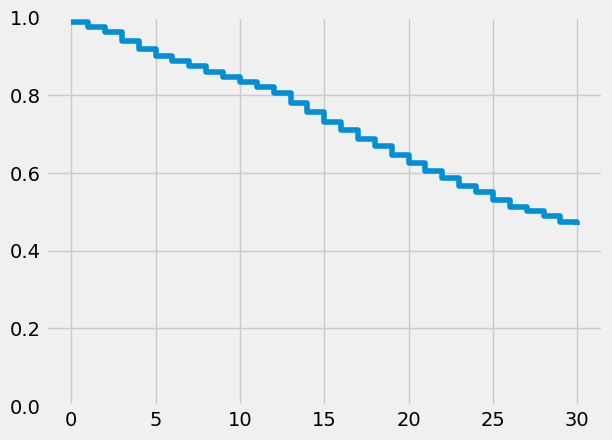

In [11]:
from sksurv.nonparametric import kaplan_meier_estimator 

time, survival_prob = \
    kaplan_meier_estimator(
    trainInput.purchased.astype(bool), 
    trainInput["days_on_market"]) 

fig, ax = plt.subplots()
sns.lineplot(y = survival_prob, x=time, drawstyle='steps-post')
ax.set_ylim(0,1)
plt.show()

## 5. XGBoost Survival Model

In [12]:
from sklearn.preprocessing import MinMaxScaler

# importing model and utils from xgbse
from xgbse import (XGBSEKaplanNeighbors, 
                   XGBSEDebiasedBCE,
                   XGBSEKaplanTree,
                   XGBSEStackedWeibull,
                   XGBSEBootstrapEstimator)

from xgbse.converters import convert_to_structured

# importing metrics
from xgbse.metrics import (
    concordance_index,
    approx_brier_score,
    dist_calibration_score
)

scaler = MinMaxScaler()

trainData = pd.DataFrame(scaler.fit_transform(trainData), 
                         columns=trainData.columns)

testData = pd.DataFrame(scaler.fit_transform(testData), 
                         columns=testData.columns)

X = trainData
y = convert_to_structured(trainInput['days_on_market'], trainLabels)

X_val = testData
y_val = convert_to_structured(testInput['days_on_market'], testLabels)

In [13]:
# fitting xgbse model
xgbse_model = XGBSEKaplanNeighbors(n_neighbors=5)
xgbse_model.fit(X, y)

# predicting
preds = xgbse_model.predict(X_val)

# # running metrics
print(f'C-index: {concordance_index(y_val, preds)}')
# print(f'Avg. Brier Score: {approx_brier_score(y_val, preds)}')

C-index: 0.7487488216992595


In [14]:
xgbse_model.feature_importances_

{'product_id': 12958.0, 'brand': 3672.0, 'price': 19166.0, 'color': 7421.0}

## 6. Apply to Kaggle Data

In [15]:
kaggle = pd.read_csv('kaggle.csv')
submission = kaggle.copy()
kaggle[['product_id']] = kaggle[['product_id']].astype(str)

In [16]:
kaggle.head()

,product_id,brand,price,color
0,420,samsung,242.63,black
1,20,apple,458.28,silver
2,67,apple,928.19,white
3,420,samsung,242.64,blue
4,420,samsung,242.63,silver


In [17]:
kaggle = enc.transform(kaggle)
kaggle = con.transform(kaggle)
kaggle = enc2.transform(kaggle)
kaggle = pd.DataFrame(scaler.fit_transform(kaggle), 
                         columns=kaggle.columns)

In [18]:
# predicting
submission['Expected'] = 1 - xgbse_model.predict(kaggle,time_bins=[31])

In [19]:
submission

,product_id,brand,price,color,Expected
0,420,samsung,242.63,black,0.2
1,20,apple,458.28,silver,1.0
2,67,apple,928.19,white,1.0
3,420,samsung,242.64,blue,0.0
4,420,samsung,242.63,silver,1.0
...,...,...,...,...,...
167,476,samsung,131.53,black,0.8
168,456,samsung,172.23,white,1.0
169,474,samsung,130.99,white,0.8
170,474,samsung,130.99,white,0.8


In [20]:
submission['Id'] = submission.index.astype(str)

In [21]:
submission[['Id','Expected']].to_csv('to_kaggle.csv', index = False)

Please submit to: https://www.kaggle.com/t/1fd732518dbd43539f115bf559ce5883

### 6.1. Find the top 10% products to discount in Kaggle data:

In [22]:
top_17 = submission.sort_values(by = 'Expected', ascending=True).head(17).Id.to_list()
top_17 = pd.DataFrame(top_17)
top_17.columns = ['Id']
top_17['Id']=top_17['Id'].astype(int)
top_17.to_csv("sample_top17.csv", index = False)

Please email sample_top17.csv to mousavi@virignia.edu. Please include the name and/ or number of your mod team in the email.

## XGBSE Docs:

https://github.com/loft-br/xgboost-survival-embeddings/blob/main/docs/how_xgbse_works.md